# Library

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Rescaling, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
tf.keras.utils.image_dataset_from_directory
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
%matplotlib inline
from tensorflow.keras.layers import BatchNormalization

from sklearn.metrics import confusion_matrix, classification_report

# Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Project Capstone

/content/drive/MyDrive/Project Capstone


In [4]:
batch_size = 32
img_height = 224
img_width = 224

In [5]:
data_dir = "/content/drive/MyDrive/Project Capstone/datasettttttt"

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 300 files belonging to 6 classes.
Using 240 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 300 files belonging to 6 classes.
Using 60 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Abstract', 'Fauvism', 'Fiber Art', 'Japanesse Art', 'Pop Art', 'Romanticism']


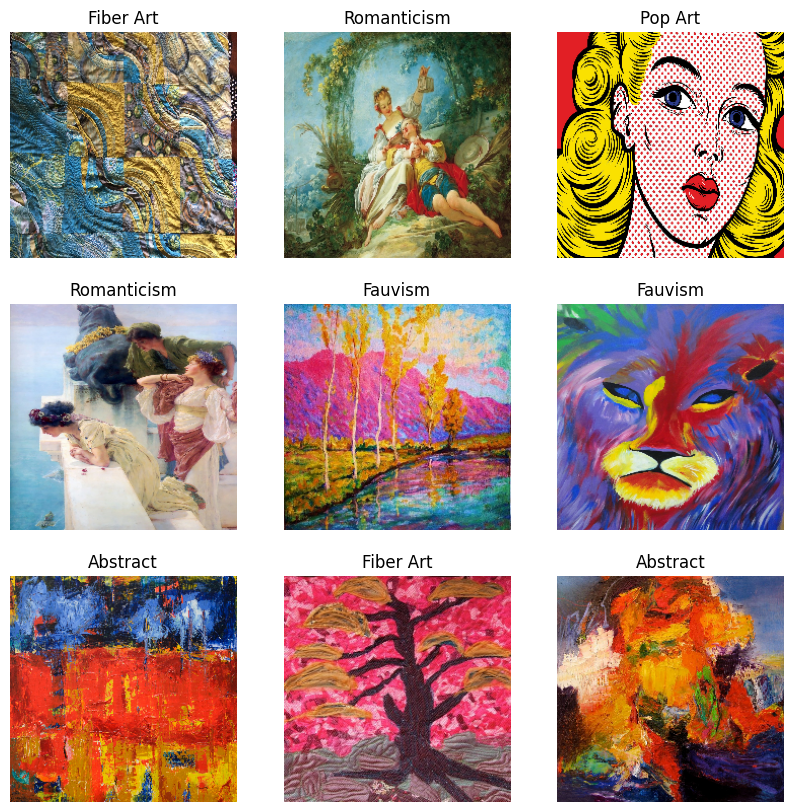

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Preprocessing

In [12]:
normalization_layer = Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [14]:
normalized_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [25]:
num_classes = len(class_names)

## MODEL



#### train_loss: 1.2067 - train_acc: 54%- val_loss: 0.9270 - val_acc: 62.5%

In [15]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
mobilenet_v3 = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"
feature_extractor_model = mobilenet_v2

In [16]:
import tensorflow_hub as hub
import datetime
from tensorflow.keras import regularizers


In [17]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [18]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [32]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
])

In [33]:
augmented_train_dataset = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [34]:
base_model = Sequential([
    feature_extractor_layer
])
base_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________


In [35]:
input_tensor = Input(shape=(224, 224, 3))

In [ ]:
#current model 
x = base_model(input_tensor)
#x = Dense(1028, activation='relu')(x)
#x = Dense(512, activation='relu')(x)
#x = Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l1(0.01))(x)
#x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1(0.01))(x)
#x = Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1(0.01))(x)
#x = Dense(32, activation='relu')(x)
x = Dense(256, activation='relu')(x) #nomor 1 learning rate 0.001
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x) #nomor 1 learning rate 0.001
x = Dropout(0.2)(x)
#x = Dense(128, activation='relu', kernel_regularizer = keras.regularizers.l1_l2(l1 = 0.1, l2 = 0.1))(x)
#x = Dense(128, activation='relu')(x) #nomor 2
#x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x) #stay
x = Dropout(0.2)(x)
#x = Dense(16, activation='relu')(x) #stay
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Model 1

# Kpan yah ga overftingg



In [36]:
#lab  model 
x = base_model(input_tensor)
x = Dense(2048, activation='relu')(x) #nomor 1 learning rate 0.001
x = BatchNormalization()(x) 
x = Dropout(0.2)(x)



predictions = Dense(num_classes, activation='softmax')(x)

In [37]:
model = Model(inputs=input_tensor, outputs=predictions)

In [38]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=4)

In [39]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
rms = RMSprop(learning_rate = 0.00001)
adam = Adam(learning_rate = 0.00001)
sgd = RMSprop(learning_rate = 0.00001)


In [40]:
model.compile(optimizer= sgd, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['acc'])

In [41]:
history = model.fit(augmented_train_dataset,
                    validation_data=val_ds,
                    epochs=100,
                    callbacks=[early_stopping,reduce_lr])

Epoch 1/100
8/8 [==============================] - 19s 2s/step - loss: 2.2983 - acc: 0.2167 - val_loss: 1.9209 - val_acc: 0.1333 - lr: 1.0000e-05
Epoch 2/100
8/8 [==============================] - 14s 2s/step - loss: 2.1122 - acc: 0.2500 - val_loss: 1.8704 - val_acc: 0.1333 - lr: 1.0000e-05
Epoch 3/100
8/8 [==============================] - 14s 2s/step - loss: 1.8977 - acc: 0.2792 - val_loss: 1.8316 - val_acc: 0.1500 - lr: 1.0000e-05
Epoch 4/100
8/8 [==============================] - 14s 2s/step - loss: 1.6965 - acc: 0.3667 - val_loss: 1.8038 - val_acc: 0.2000 - lr: 1.0000e-05
Epoch 5/100
8/8 [==============================] - 13s 2s/step - loss: 1.5932 - acc: 0.3833 - val_loss: 1.7680 - val_acc: 0.2000 - lr: 1.0000e-05
Epoch 6/100
8/8 [==============================] - 14s 2s/step - loss: 1.6608 - acc: 0.3792 - val_loss: 1.7285 - val_acc: 0.2333 - lr: 1.0000e-05
Epoch 7/100
8/8 [==============================] - 12s 2s/step - loss: 1.4576 - acc: 0.4458 - val_loss: 1.6928 - val_acc: 0.

In [42]:
model.compile(optimizer= rms, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['acc'])

In [43]:
history = model.fit(augmented_train_dataset,
                    validation_data=val_ds,
                    epochs=100,
                    callbacks=[early_stopping,reduce_lr])

Epoch 1/100
8/8 [==============================] - 15s 2s/step - loss: 0.7862 - acc: 0.7625 - val_loss: 1.3347 - val_acc: 0.5167 - lr: 1.0000e-05
Epoch 2/100
8/8 [==============================] - 11s 1s/step - loss: 0.8360 - acc: 0.6833 - val_loss: 1.3300 - val_acc: 0.5333 - lr: 1.0000e-05
Epoch 3/100
8/8 [==============================] - 11s 1s/step - loss: 0.8019 - acc: 0.7208 - val_loss: 1.3398 - val_acc: 0.5000 - lr: 1.0000e-05
Epoch 4/100
8/8 [==============================] - 12s 2s/step - loss: 0.7813 - acc: 0.7208 - val_loss: 1.3349 - val_acc: 0.5000 - lr: 1.0000e-05
Epoch 5/100
8/8 [==============================] - 12s 1s/step - loss: 0.7374 - acc: 0.7417 - val_loss: 1.3401 - val_acc: 0.5333 - lr: 1.0000e-05
Epoch 6/100
8/8 [==============================] - 12s 2s/step - loss: 0.7591 - acc: 0.6917 - val_loss: 1.3446 - val_acc: 0.5500 - lr: 1.0000e-05
Epoch 7/100
8/8 [==============================] - 12s 2s/step - loss: 0.7131 - acc: 0.7625 - val_loss: 1.3485 - val_acc: 0.

In [44]:
model.compile(optimizer= adam, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['acc'])

In [45]:
history = model.fit(augmented_train_dataset,
                    validation_data=val_ds,
                    epochs=100,
                    callbacks=[early_stopping,reduce_lr])

Epoch 1/100
8/8 [==============================] - 16s 2s/step - loss: 0.7992 - acc: 0.6958 - val_loss: 1.3238 - val_acc: 0.5167 - lr: 1.0000e-05
Epoch 2/100
8/8 [==============================] - 13s 2s/step - loss: 0.8154 - acc: 0.7292 - val_loss: 1.3249 - val_acc: 0.5000 - lr: 1.0000e-05
Epoch 3/100
8/8 [==============================] - 12s 1s/step - loss: 0.7661 - acc: 0.7083 - val_loss: 1.3175 - val_acc: 0.5000 - lr: 1.0000e-05
Epoch 4/100
8/8 [==============================] - 13s 2s/step - loss: 0.7891 - acc: 0.6875 - val_loss: 1.3120 - val_acc: 0.5167 - lr: 1.0000e-05
Epoch 5/100
8/8 [==============================] - 11s 1s/step - loss: 0.7478 - acc: 0.7083 - val_loss: 1.3126 - val_acc: 0.5333 - lr: 1.0000e-05
Epoch 6/100
8/8 [==============================] - 13s 2s/step - loss: 0.7962 - acc: 0.6667 - val_loss: 1.3139 - val_acc: 0.5333 - lr: 1.0000e-05
Epoch 7/100
8/8 [==============================] - 13s 2s/step - loss: 0.7180 - acc: 0.7375 - val_loss: 1.3152 - val_acc: 0.

ValueError: ignored

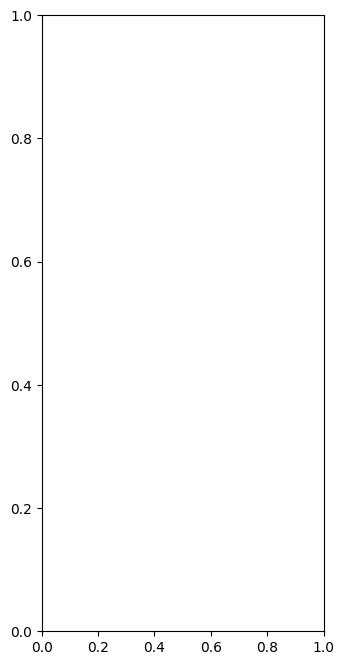

In [46]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = 16
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()